In [1]:
import nest_asyncio
nest_asyncio.apply()

In [2]:
import collections

import numpy as np
import tensorflow as tf
import tensorflow_federated as tff

tff.backends.reference.set_reference_context()

In [3]:
import sys
sys.path.append("../")
from federated.data.data_preprocessing import load_data, create_unbalanced_data

In [4]:
NUMBER_OF_CLIENTS=5
CLIENT_EPOCHS=10
BATCH_SIZE=32
NUM_EXAMPLES_PER_USER = 20_000

In [5]:
train_client_data, test_client_data = load_data(normalized=True, data_selector=create_unbalanced_data)

In [6]:
def get_data_for_ecg(source, client):
    output_sequence = []
    data = source[f"client_{client}"]
    all_samples = [i for i, y in enumerate(data[1])]
    for i in range(0, min(len(all_samples), NUM_EXAMPLES_PER_USER), BATCH_SIZE):
        batch_samples = all_samples[i:i + BATCH_SIZE]
        output_sequence.append({
            "x": np.array([data[0][i] for i in batch_samples], dtype=np.float32),
            "y": np.array([np.where(data[1][i]==1)[0][0] for i in batch_samples], dtype=np.int32)
        })
    return output_sequence

federated_train_data = [get_data_for_ecg(train_client_data, client) for client in range(1, 6)]

federated_test_data = [get_data_for_ecg(train_client_data, client) for client in range(1, 6)]

In [7]:
BATCH_SPEC = collections.OrderedDict(
    x=tf.TensorSpec(shape=[None, 186], dtype=tf.float32),
    y=tf.TensorSpec(shape=[None], dtype=tf.int32))
BATCH_TYPE = tff.to_type(BATCH_SPEC)

str(BATCH_TYPE)

'<x=float32[?,186],y=int32[?]>'

In [8]:
MODEL_SPEC = collections.OrderedDict(
    weights=tf.TensorSpec(shape=[186, 5], dtype=tf.float32),
    bias=tf.TensorSpec(shape=[5], dtype=tf.float32))
MODEL_TYPE = tff.to_type(MODEL_SPEC)

print(MODEL_TYPE)

<weights=float32[186,5],bias=float32[5]>


In [9]:
@tf.function
def forward_pass(model, batch):
    predicted_y = tf.nn.softmax(
        tf.matmul(batch['x'], model['weights']) + model['bias'])
    return -tf.reduce_mean(
        tf.reduce_sum(
            tf.one_hot(batch['y'], 5) * tf.math.log(predicted_y), axis=[1]))

@tff.tf_computation(MODEL_TYPE, BATCH_TYPE)
def batch_loss(model, batch):
    return forward_pass(model, batch)

In [10]:
initial_model = collections.OrderedDict(
    weights=np.zeros([186, 5], dtype=np.float32),
    bias=np.zeros([5], dtype=np.float32))

sample_batch = federated_train_data[4][-1]

batch_loss(initial_model, sample_batch)

1.609438

In [11]:
@tff.tf_computation(MODEL_TYPE, BATCH_TYPE, tf.float32)
def batch_train(initial_model, batch, learning_rate):
    # Define a group of model variables and set them to `initial_model`. Must
    # be defined outside the @tf.function
    model_vars = collections.OrderedDict([
        (name, tf.Variable(name=name, initial_value=value))
        for name, value in initial_model.items()
    ])
    optimizer = tf.keras.optimizers.SGD(learning_rate)

    @tf.function
    def _train_on_batch(model_vars, batch):
        # Perform one step gradient descent using loss from `batch_loss`.
        with tf.GradientTape() as tape:
            loss = forward_pass(model_vars, batch)
        grads = tape.gradient(loss, model_vars)
        optimizer.apply_gradients(
            zip(tf.nest.flatten(grads), tf.nest.flatten(model_vars)))
        return model_vars

    return _train_on_batch(model_vars, batch)

In [12]:
LOCAL_DATA_TYPE = tff.SequenceType(BATCH_TYPE)

@tff.federated_computation(MODEL_TYPE, tf.float32, LOCAL_DATA_TYPE)
def local_train(initial_model, learning_rate, all_batches):

    # Mapping function to apply to each batch
    @tff.federated_computation(MODEL_TYPE, BATCH_TYPE)
    def batch_fn(model, batch):
        return batch_train(model, batch, learning_rate)
    
    return tff.sequence_reduce(all_batches, initial_model, batch_fn)

In [13]:
locally_trained_model = local_train(initial_model, 0.1, federated_train_data[4])

In [14]:
@tff.federated_computation(MODEL_TYPE, LOCAL_DATA_TYPE)
def local_eval(model, all_batches):
    return tff.sequence_sum(
        tff.sequence_map(
            tff.federated_computation(lambda b: batch_loss(model, b), BATCH_TYPE),
            all_batches))

In [15]:
print('initial_model loss =', local_eval(initial_model,
                                          federated_train_data[4]))

print('locally_trained_model loss =',
      local_eval(locally_trained_model, federated_train_data[4]))

initial_model loss = 1005.8976
locally_trained_model loss = 327.7455


In [16]:
print('initial_model loss =', local_eval(initial_model,
                                          federated_train_data[0]))

print('locally_trained_model loss =',
      local_eval(locally_trained_model, federated_train_data[0]))

initial_model loss = 1005.8976
locally_trained_model loss = 4177.9453


In [17]:
SERVER_MODEL_TYPE = tff.type_at_server(MODEL_TYPE)
CLIENT_DATA_TYPE = tff.type_at_clients(LOCAL_DATA_TYPE)

In [18]:
@tff.federated_computation(SERVER_MODEL_TYPE, CLIENT_DATA_TYPE)
def federated_eval(model, data):
    return tff.federated_mean(
        tff.federated_map(local_eval, [tff.federated_broadcast(model), data]))

In [19]:
print('initial_model loss =', federated_eval(initial_model,
                                          federated_train_data))

print('locally_trained_model loss =',
      federated_eval(locally_trained_model, federated_train_data))

initial_model loss = 1003.9663
locally_trained_model loss = 1097.4113


In [20]:
SERVER_FLOAT_TYPE = tff.type_at_server(tf.float32)

@tff.federated_computation(
    SERVER_MODEL_TYPE, SERVER_FLOAT_TYPE, CLIENT_DATA_TYPE)
def grab_all_models(model, learning_rate, data):
  return tff.federated_collect(
      tff.federated_map(
          local_train,
          [tff.federated_broadcast(model),
           tff.federated_broadcast(learning_rate),
           data]))

@tff.federated_computation(SERVER_MODEL_TYPE, SERVER_FLOAT_TYPE,
                           CLIENT_DATA_TYPE)
def federated_train(model, learning_rate, data):
    return tff.federated_mean(
        tff.federated_map(local_train, [
            tff.federated_broadcast(model),
            tff.federated_broadcast(learning_rate), data
        ]))

In [21]:
keras_model = tf.keras.models.load_model("../history/logdir/fedavg_linear_dp_v2")
weights = keras_model.layers[1].get_weights()[0]
biases = keras_model.layers[1].get_weights()[1]

print(weights.shape)
print(biases.shape)

(186, 5)
(5,)


In [22]:
model = collections.OrderedDict(
    weights=weights,
    bias=biases)

In [23]:
models = grab_all_models(model, 0.1, federated_train_data)

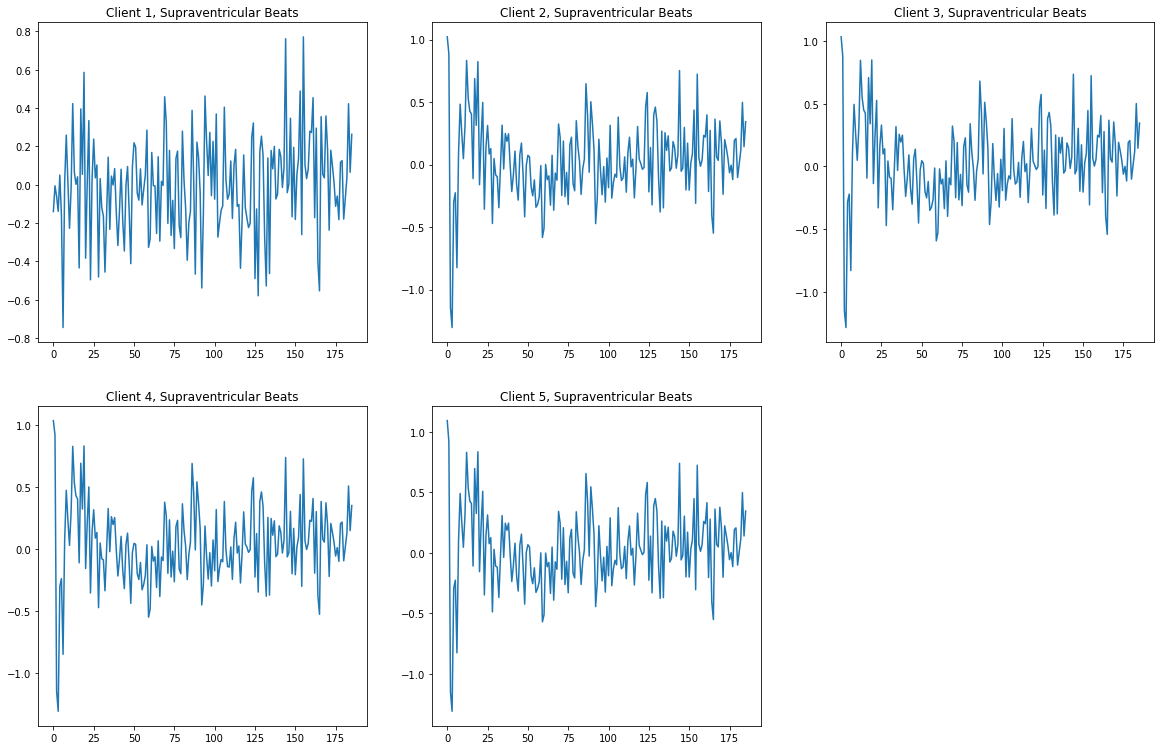

In [26]:
import matplotlib.pyplot as plt

illness = ["Normal beats", "Supraven.", "Ventricular", "Fusion", "Unknown"]
#fig, axs = plt.subplots(5, 2, figsize=(20,20))

plt.figure(figsize=(20, 20))

for i in range(5):
    model = models[i]
    plt.subplot(3,3,i+1)
    plt.plot(model["weights"][:, 1])
    plt.title(f"Client {i+1}, Supraventricular Beats")

plt.savefig(f"images/weight_extraction_supra_dp.pdf", bbox_inches='tight')